# Project 4 - WEST NILE VIRUS

## Problem Statement

West Nile virus can cause a fatal neurological disease in humans. It is mainly transmitted to people through the bites of infected mosquitoes. Treatments often involve hospitalization, intravenous fluids, respiratory support, and prevention of secondary infections. 

No vaccine is available for humans. 

Studies estimated the economic impact of the WNV disease outbreak in 2002 in Louisiana, which resulted in 24 deaths. Total epidemic costs were about 20.14 million for the 329 cases, including 9.2 million for mosquito control and public health agency costs. As mosquito control is an expensive exercise, the state would like our team to propose a cost-effective plan for pesticide deployment.

## Executive Summary

If you want to, it's great to use relative links to direct your audience to various sections of a notebook. **HERE'S A DEMONSTRATION WITH THE CURRENT SECTION HEADERS**:

### Contents: (TOBE UPDATED)
- [2017 Data Import & Cleaning](#Data-Import-and-Cleaning)
- [2018 Data Import and Cleaning](#2018-Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-data)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)
- [Outside Research](#Outside-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

**If you combine your problem statement, executive summary, data dictionary, and conclusions/recommendations, you have an amazing README.md file that quickly aligns your audience to the contents of your project.** Don't forget to cite your data sources!

*All libraries used should be added here*

In [1]:
# import libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread

sns.set(font_scale=1.5)
%matplotlib inline

## Data Import and Cleaning

In [4]:
# import data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

### TRAIN & TEST DATA

In [5]:
# delete variables that are not useful
# address related are deleted as location is determined by Latitude and Longuitude
# checked online all species are relevant for WNV
def del_var(data):
    try:
        del data['Address']
        del data['Block']
        del data['Street']
        del data['AddressNumberAndStreet']
        del data['AddressAccuracy']
        del data['Species']
    except:
        pass

In [6]:
del_var(train)

In [7]:
del_var(test)

In [8]:
# combine test results for traps with multiple rows in any single day, since we are ignoring species
import datetime
def aggregate_train(data):
    grouped = data.groupby(['Date', 'Trap', 'Latitude', 'Longitude'])
    aggregated = pd.DataFrame(grouped.agg({'NumMosquitos': np.sum, 'WnvPresent': np.max})).reset_index()
    aggregated.sort_values(by='NumMosquitos', ascending = False)
    aggregated.sort_values(by='Date', inplace=True)
    aggregated = aggregated.reset_index(drop = True)
    aggregated['Date'] = pd.to_datetime(aggregated.Date, format='%Y-%m-%d')
    aggregated['Year'] = pd.DatetimeIndex(aggregated['Date']).year 
    aggregated['Month'] = pd.DatetimeIndex(aggregated['Date']).month
    return aggregated

def aggregate_test(data):
    data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
    data['Year'] = pd.DatetimeIndex(data['Date']).year 
    data['Month'] = pd.DatetimeIndex(data['Date']).month
    return data

In [9]:
agg_train = aggregate_train(train)

In [10]:
agg_test = aggregate_test(test)

In [11]:
# there are no missing data in agg_train
agg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 8 columns):
Date            4616 non-null datetime64[ns]
Trap            4616 non-null object
Latitude        4616 non-null float64
Longitude       4616 non-null float64
NumMosquitos    4616 non-null int64
WnvPresent      4616 non-null int64
Year            4616 non-null int64
Month           4616 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 288.6+ KB


In [12]:
# there are no missing data in agg_test
agg_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 7 columns):
Id           116293 non-null int64
Date         116293 non-null datetime64[ns]
Trap         116293 non-null object
Latitude     116293 non-null float64
Longitude    116293 non-null float64
Year         116293 non-null int64
Month        116293 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 6.2+ MB


In [13]:
import math
# source: https://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [14]:
# weather stations 1 and 2 lat/longitude
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station_1_lat = 41.995
station_1_lon = -87.933
station_2_lat = 41.786
station_2_lon = -87.752
# function to calculate whether station 1 or 2 (from weather.csv) is closer
def closest_station(lat, lon):
    if (distance_on_unit_sphere(lat, lon, station_1_lat, station_1_lon) <
        distance_on_unit_sphere(lat, lon, station_2_lat, station_2_lon)):
        return 1
    else: return 2

In [15]:
## REVISED 3/8/2019
# add station to indicate whether station 1 or 2 is closer
# create unique variable to combine train, weather and spray data
def station_var (data):
    data['Station'] = [closest_station(a,b) for (a, b) in zip(data.Latitude, data.Longitude)]
    data['unique'] =  data['Station'].astype(str) + str(": ") + data['Date'].astype(str)

In [16]:
station_var(agg_train)
station_var(agg_test)

###  WEATHER DATA

In [17]:
# Many numerical columns are imported as objects
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [18]:
# Convert Date to date format
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')

In [19]:
# Calculate missing Tavg as average of Tmax and Tmin
weather['Tavg'] = weather.apply([lambda row: (row.Tmax + row.Tmin) / 2 if row.Tavg == 'M' else row.Tavg], axis=1)
weather['Tavg'] = pd.to_numeric(weather['Tavg'])

In [20]:
# Fill missing WetBulb from the other station
for k, v in enumerate(weather['WetBulb']):
    if v == 'M' and weather.iloc[k]['Station'] == 1:
        weather.loc[k,'WetBulb'] = weather['WetBulb'][k+1]
    if v == 'M' and weather.iloc[k]['Station'] == 2:
        weather.loc[k,'WetBulb'] = weather['WetBulb'][k-1]
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])

In [21]:
# Engineer feature for daytime in minutes
sunset = pd.to_timedelta([i[:2] + ':' + i[2:] + ':00' for i in weather[weather['Station']==1]['Sunset']])
sunrise = pd.to_timedelta([i[:2] + ':' + i[2:] + ':00' for i in weather[weather['Station']==1]['Sunrise']])
daytime = sunset - sunrise
daytime_m = list([int(str(i).split(":")[0][-2:]) * 60 + int(str(i).split(":")[1]) for i in daytime])
weather['Daytime'] = list(sum((zip(daytime_m,daytime_m)),()))

In [22]:
# Fill trace values as 0.005
weather['PrecipTotal'].replace('  T', '0.005', inplace=True)
# Fill missing values from the other Station
for k, v in enumerate(weather['PrecipTotal']):
    if v == 'M' and weather.iloc[k]['Station'] == 1:
        weather.loc[k,'PrecipTotal'] = weather['PrecipTotal'][k+1]
    if v == 'M' and weather.iloc[k]['Station'] == 2:
        weather.loc[k,'PrecipTotal'] = weather['PrecipTotal'][k-1]
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])

In [23]:
# Fill missing values for Depart, Heat, Cool, AvgSpeed from the other station
cols = ['Depart', 'Heat', 'Cool', 'AvgSpeed']
for col in cols:
    for k, v in enumerate(weather[col]):
        if v == 'M' and weather.iloc[k]['Station'] == 1:
            weather.loc[k,col] = weather[col][k+1]
        if v == 'M' and weather.iloc[k]['Station'] == 2:
            weather.loc[k,col] = weather[col][k-1]
    weather[col] = pd.to_numeric(weather[col])

In [24]:
# Check column data types after cleaning
# We skipped cleaning for CodeSum, Depth, Water1, SnowFall, StnPressure, SeaLevel
# because we do not find them useful
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
Depart                  int64
DewPoint                int64
WetBulb                 int64
Heat                    int64
Cool                    int64
Sunrise                object
Sunset                 object
CodeSum                object
Depth                  object
Water1                 object
SnowFall               object
PrecipTotal           float64
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
Daytime                 int64
dtype: object

## Combine weather & train/test data for ease of analysis

In [25]:
# create unique variable to combine train and weather data
weather['unique'] = weather['Station'].astype(str) + str(": ") + weather['Date'].astype(str)

In [26]:
combined_train = pd.merge(agg_train, weather, how="inner", on="unique")
combined_test = pd.merge(agg_test, weather, how="inner", on="unique")

In [27]:
# dropping duplicate and unnecessary variables
combined_train = combined_train.drop(["Date_y", "Station_y", "unique"], axis=1)
combined_train.rename(columns={"Date_x": "Date"}, inplace=True)
combined_train.rename(columns={"Station_x": "Station"}, inplace=True)
combined_test = combined_test.drop(["Date_y", "Station_y", "unique"], axis=1)
combined_test.rename(columns={"Station_x": "Station"}, inplace=True)

# NEW 3/8/2019 - to create YYMM
# bin the surveillance efforts by month
combined_train ["YYMM"] = tuple(zip(combined_train.Year, combined_train.Month))
combined_test ["YYMM"] = tuple(zip(combined_test.Year, combined_test.Month))

In [28]:
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Data columns (total 31 columns):
Date            4616 non-null datetime64[ns]
Trap            4616 non-null object
Latitude        4616 non-null float64
Longitude       4616 non-null float64
NumMosquitos    4616 non-null int64
WnvPresent      4616 non-null int64
Year            4616 non-null int64
Month           4616 non-null int64
Station         4616 non-null int64
Tmax            4616 non-null int64
Tmin            4616 non-null int64
Tavg            4616 non-null float64
Depart          4616 non-null int64
DewPoint        4616 non-null int64
WetBulb         4616 non-null int64
Heat            4616 non-null int64
Cool            4616 non-null int64
Sunrise         4616 non-null object
Sunset          4616 non-null object
CodeSum         4616 non-null object
Depth           4616 non-null object
Water1          4616 non-null object
SnowFall        4616 non-null object
PrecipTotal     4616 non-null float64
StnPr

In [29]:
# how many trap observations per month
combined_train["YYMM"].value_counts().sort_index()

(2007, 5)      18
(2007, 6)     120
(2007, 7)     260
(2007, 8)     574
(2007, 9)     382
(2007, 10)    105
(2009, 5)      41
(2009, 6)     255
(2009, 7)     285
(2009, 8)     180
(2009, 9)     208
(2009, 10)     37
(2011, 6)     193
(2011, 7)     263
(2011, 8)     252
(2011, 9)     280
(2013, 6)     248
(2013, 7)     285
(2013, 8)     357
(2013, 9)     273
Name: YYMM, dtype: int64

## Data Cleaning - Spray Data

In [30]:
#NEW 3/8/2019 - to create YYMM
spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')
spray['Year'] = pd.DatetimeIndex(spray['Date']).year 
spray['Month'] = pd.DatetimeIndex(spray['Date']).month
spray["YYMM"] = tuple(zip(spray.Year, spray.Month))
del spray['Time']

In [31]:
# there are no missing data in spray
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 6 columns):
Date         14835 non-null datetime64[ns]
Latitude     14835 non-null float64
Longitude    14835 non-null float64
Year         14835 non-null int64
Month        14835 non-null int64
YYMM         14835 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 695.5+ KB


## EDA

#### Maps of WNV by year

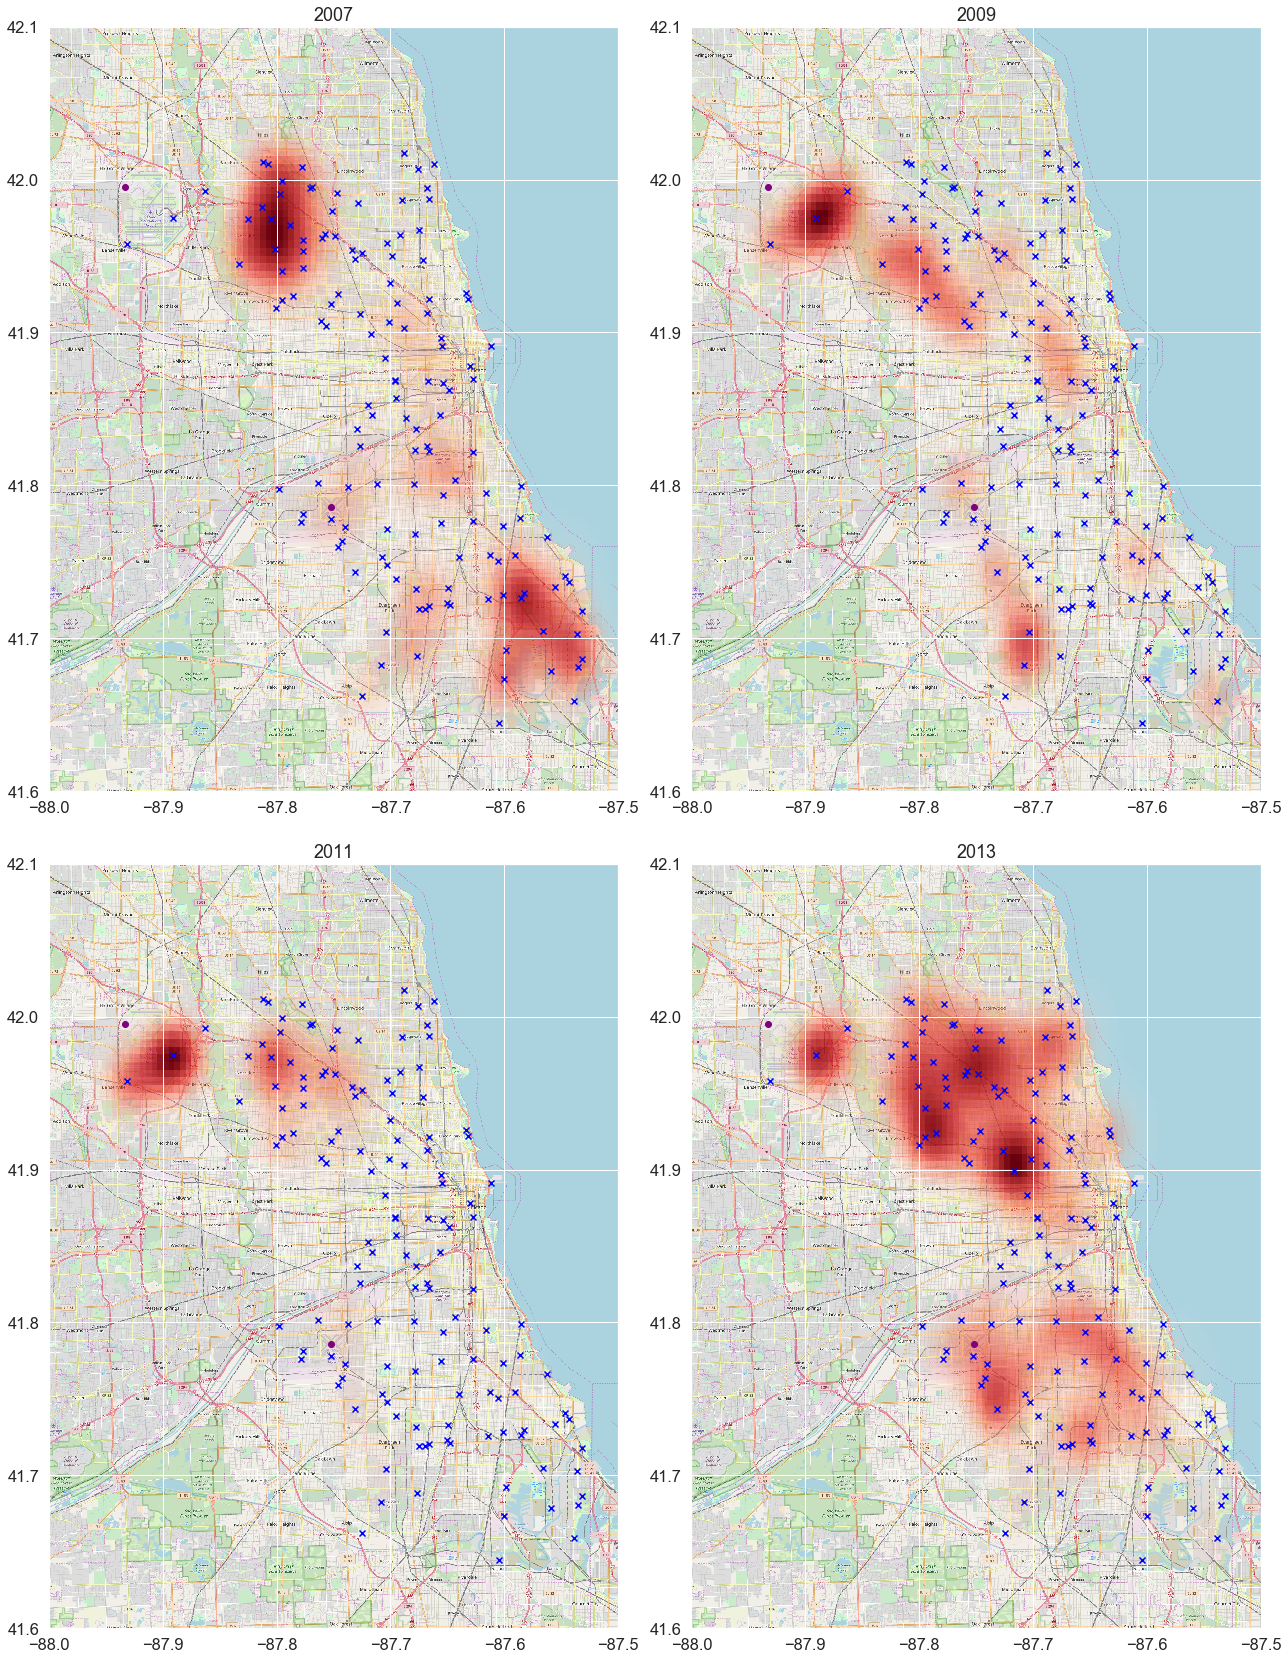

In [32]:
# source: https://www.kaggle.com/neilsummers/west-nile-heatmap-by-year
from sklearn.neighbors import KernelDensity

mapdata = plt.imread('../data/map1.png')
traps = pd.read_csv('../data/train.csv', parse_dates=['Date'])[['Date', 'Trap', 'Longitude', 'Latitude', 'WnvPresent']]

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = np.linspace(0, 1, alpha_cm.N)
aspect = mapdata.shape[0] / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(18,24))
for year, subplot in zip([2007, 2009, 2011, 2013], [221, 222, 223, 224]):
    sightings = traps[(traps['WnvPresent'] > 0) & (traps['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap', 'Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)
    plt.imshow(mapdata,
               extent=lon_lat_box,
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower',
               cmap=alpha_cm,
               extent=lon_lat_box,
               aspect=aspect)
    plt.tight_layout()
    locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], c='blue', marker='x')
    plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c='purple', marker='o')

#### Maps of Spray activities by year

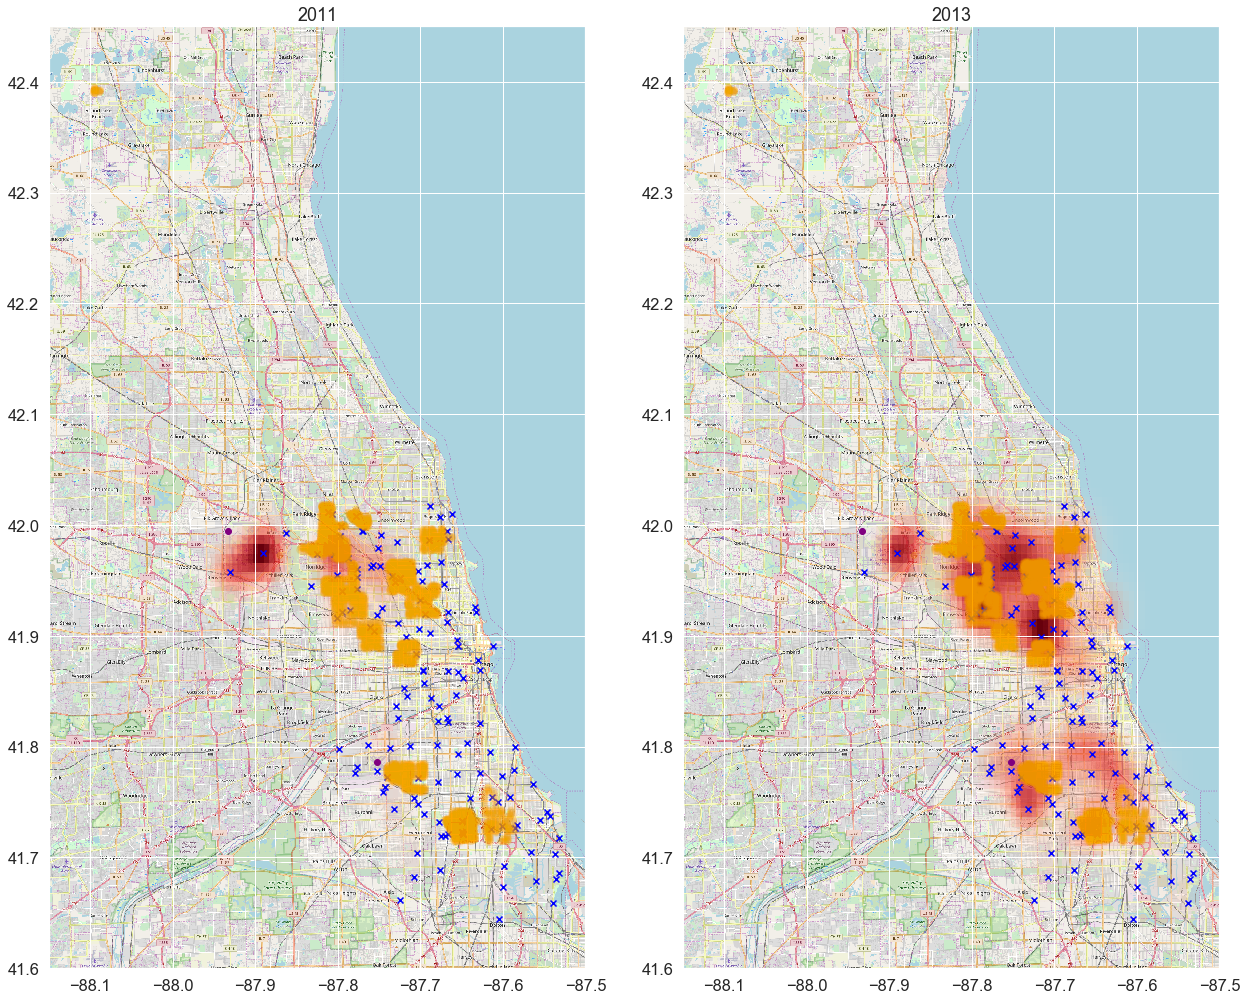

In [33]:
mapdata = imread('../data/map2.png')

lon_lat_box = (-88.15, -87.5, 41.6, 42.45)

plt.figure(figsize=(18,14))
for year, subplot in zip([2011, 2013], [121, 122]):
    sightings = traps[(traps['WnvPresent'] > 0) & (traps['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88.15, -87.5, 100), np.linspace(41.6, 42.45, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)
    plt.imshow(mapdata,
               extent=lon_lat_box,
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower',
               cmap=alpha_cm,
               extent=lon_lat_box,
               aspect=aspect)
    plt.tight_layout()
    locations_trap = traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_trap[:,0], locations_trap[:,1], c='blue', marker='x')
    plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c='purple', marker='o')
    locations_spray = spray[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_spray[:,0], locations_spray[:,1], c='orange', alpha=0.05)

#### Pairplot for weather data

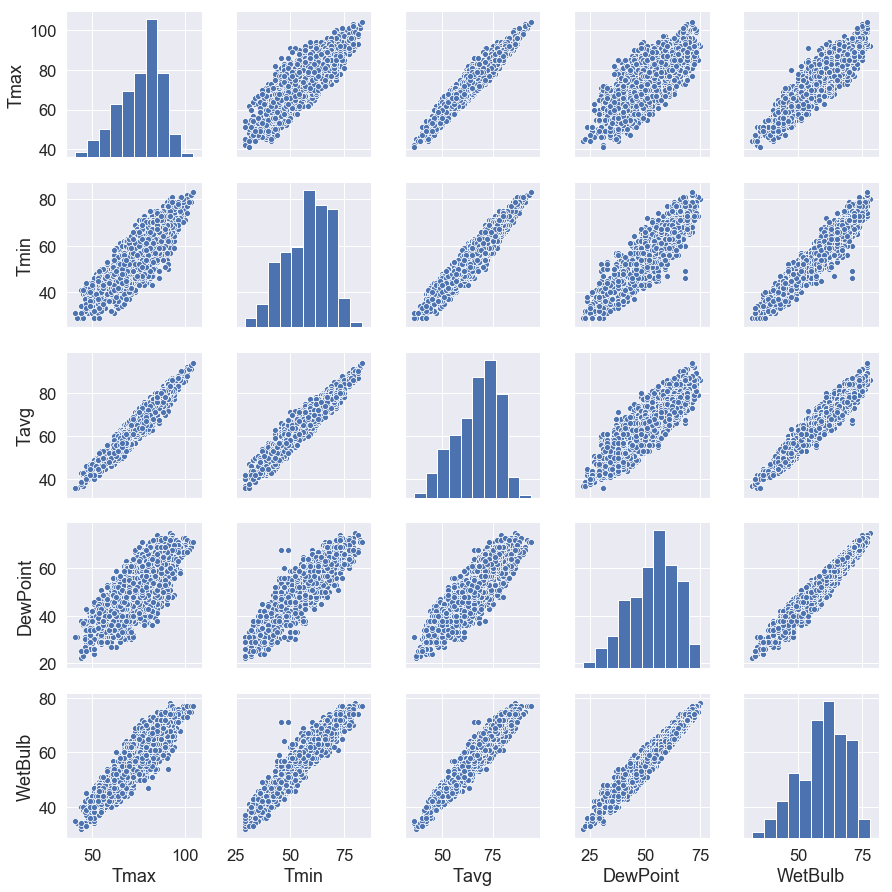

In [34]:
# look at relationships between features describing temperature
sns.pairplot(weather[['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb']])

#### Visualizing the trap locations in comparison with the two weather stations

In [35]:
# not necessary anymore
"""
# look at dispersion of traps geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.Station)
plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c = 'r')
plt.show()
"""

"\n# look at dispersion of traps geographically\nplt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.Station)\nplt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c = 'r')\nplt.show()\n"

#### Top 20 locations of highest number of mosquitoes

In [36]:
## revised 5/8/2019
#top 20 locations of highest number of mosquitoes
lat_long = combined_train.groupby(["Latitude","Longitude"])['NumMosquitos'].agg(['mean','count'])
lat_long= lat_long.sort_values(by="mean", ascending=False).head(20)
#total_mosquitoes = total_mosquitoes.reset_index()
#sum = total no. of mosquitoes in the location
#count = no. of counts (by unique days)

lat_long

mean  count
Latitude  Longitude                    
41.673408 -87.599862  328.303030     66
41.974689 -87.890615  284.925926     54
41.702724 -87.536497  249.000000     12
41.726465 -87.585413  157.714286     63
41.688324 -87.676709   69.052632     19
41.686398 -87.531635   65.538462     13
41.704572 -87.565666   58.157895     57
41.954690 -87.800991   55.373134     67
41.743402 -87.731435   49.121951     41
41.957799 -87.930995   48.479167     48
41.662014 -87.724608   47.303030     66
41.680946 -87.535198   44.741379     58
42.008314 -87.777921   44.466667     60
41.682587 -87.707973   42.916667     60
41.798697 -87.736812   36.627119     59
41.992478 -87.862995   36.024390     41
41.981964 -87.812827   35.615385     13
41.731922 -87.677512   34.000000     17
41.659112 -87.538693   33.980000     50
41.678618 -87.559308   32.571429     42

In [37]:
## revised 5/8/2019
#period with highest number of mosquitoes 
total_mosquitoes = combined_train.groupby(["YYMM"])['NumMosquitos'].agg(['mean','count'])
total_mosquitoes= total_mosquitoes.sort_values(by="mean", ascending=False).head(20)
#total_mosquitoes = total_mosquitoes.reset_index()

total_mosquitoes

mean  count
YYMM                        
(2007, 8)   69.712544    574
(2013, 7)   44.810526    285
(2013, 8)   35.593838    357
(2011, 7)   32.110266    263
(2009, 7)   30.992982    285
(2009, 6)   28.980392    255
(2007, 7)   27.688462    260
(2007, 9)   24.345550    382
(2013, 9)   22.912088    273
(2011, 6)   20.979275    193
(2013, 6)   18.995968    248
(2007, 10)  16.247619    105
(2009, 8)   13.033333    180
(2011, 9)   11.917857    280
(2011, 8)   11.777778    252
(2009, 9)   10.274038    208
(2009, 10)   5.729730     37
(2009, 5)    4.634146     41
(2007, 6)    3.566667    120
(2007, 5)    2.222222     18

In [38]:
## revised 5/8/2019
#period with highest number of WNV presents
total_WNV = combined_train.groupby(["YYMM"])['WnvPresent'].agg(['mean','count'])
total_WNV= total_WNV.sort_values(by="mean", ascending=False).head(20)

total_WNV

mean  count
YYMM                       
(2013, 8)   0.266106    357
(2007, 8)   0.222997    574
(2013, 9)   0.194139    273
(2011, 9)   0.075000    280
(2013, 7)   0.070175    285
(2011, 8)   0.063492    252
(2007, 9)   0.060209    382
(2009, 8)   0.044444    180
(2011, 7)   0.026616    263
(2009, 9)   0.024038    208
(2007, 10)  0.019048    105
(2009, 7)   0.014035    285
(2007, 7)   0.007692    260
(2013, 6)   0.004032    248
(2007, 6)   0.000000    120
(2009, 10)  0.000000     37
(2011, 6)   0.000000    193
(2009, 6)   0.000000    255
(2009, 5)   0.000000     41
(2007, 5)   0.000000     18

In [39]:
## revised 5/8/2019
#traps corresponding to the locations of highest number of mosquitoes 
total_mosquitoes = combined_train.groupby(["Trap"])['NumMosquitos'].agg(['mean','count'])
total_mosquitoes= total_mosquitoes.sort_values(by="mean", ascending=False).head(20)
#total_mosquitoes = total_mosquitoes.reset_index()

total_mosquitoes

mean  count
Trap                   
T115  328.303030     66
T900  284.925926     54
T103  249.000000     12
T138  157.714286     63
T086   69.052632     19
T215   65.538462     13
T128   58.157895     57
T002   55.373134     67
T225   49.121951     41
T903   48.479167     48
T135   47.303030     66
T212   44.741379     58
T008   44.466667     60
T158   42.916667     60
T114   36.627119     59
T009   35.925926     54
T096   34.000000     17
T221   33.980000     50
T200   32.571429     42
T223   32.025000     40

#### No. of Mosquitoes by Temp

In [40]:
combined_train_ = combined_train[combined_train["WnvPresent"]== 1]
combined_train_

Date  Trap   Latitude  Longitude  NumMosquitos  WnvPresent  Year  \
305  2007-07-18  T215  41.686398 -87.531635            85           1  2007   
346  2007-07-25  T115  41.673408 -87.599862          3002           1  2007   
398  2007-08-01  T096  41.731922 -87.677512            41           1  2007   
403  2007-08-01  T103  41.702724 -87.536497           510           1  2007   
406  2007-08-01  T081  41.821582 -87.627796            24           1  2007   
411  2007-08-01  T090  41.868077 -87.666901            93           1  2007   
413  2007-08-01  T086  41.688324 -87.676709           340           1  2007   
417  2007-08-01  T082  41.803423 -87.642984           123           1  2007   
421  2007-08-01  T138  41.726465 -87.585413           909           1  2007   
436  2007-08-01  T135  41.662014 -87.724608           159           1  2007   
456  2007-08-01  T065  41.778297 -87.752411            49           1  2007   
470  2007-08-01  T220  41.963976 -87.691810             2           1  2007   
477  2007-08-01  T144  41.940160 -87.794896            54           1  2007   
487  2007-08-01  T015  41.974089 -87.824812            18           1  2007   
492  2007-08-01  T008  42.008314 -87.777921           161           1  2007   
497  2007-08-01  T002  41.954690 -87.800991           179           1  2007   
506  2007-08-02  T138  41.726465 -87.585413          1075           1  2007   
513  2007-08-02  T212  41.680946 -87.535198           340           1  2007   
534  2007-08-02  T096  41.731922 -87.677512            49           1  2007   
554  2007-08-07  T082  41.803423 -87.642984            24           1  2007   
559  2007-08-07  T162  41.725517 -87.614258            15           1  2007   
561  2007-08-07  T160  41.903002 -87.688267            26           1  2007   
600  2007-08-07  T143  41.999129 -87.795585            44           1  2007   
612  2007-08-07  T016  42.011601 -87.811506            69           1  2007   
613  2007-08-07  T015  41.974089 -87.824812            39           1  2007   
614  2007-08-07  T014  41.970248 -87.787992            73           1  2007   
616  2007-08-07  T011  41.944869 -87.832763            72           1  2007   
618  2007-08-07  T008  42.008314 -87.777921           140           1  2007   
625  2007-08-08  T103  41.702724 -87.536497           249           1  2007   
627  2007-08-08  T115  41.673408 -87.599862          1625           1  2007   
...         ...   ...        ...        ...           ...         ...   ...   
4421 2013-09-12  T114  41.798697 -87.736812            23           1  2013   
4422 2013-09-12  T102  41.750498 -87.605294            16           1  2013   
4426 2013-09-12  T135  41.662014 -87.724608            18           1  2013   
4428 2013-09-12  T090  41.868077 -87.666901            21           1  2013   
4430 2013-09-12  T235  41.776428 -87.627096            27           1  2013   
4431 2013-09-12  T232  41.912563 -87.668055             8           1  2013   
4435 2013-09-12  T225  41.743402 -87.731435            53           1  2013   
4446 2013-09-12  T039  41.911824 -87.726737            14           1  2013   
4454 2013-09-12  T066  41.771660 -87.703047           105           1  2013   
4458 2013-09-12  T054  41.921965 -87.632085            96           1  2013   
4464 2013-09-12  T900  41.974689 -87.890615           485           1  2013   
4469 2013-09-12  T223  41.973845 -87.805059             5           1  2013   
4471 2013-09-12  T028  41.986921 -87.689778            82           1  2013   
4472 2013-09-12  T027  41.984809 -87.728492            24           1  2013   
4474 2013-09-12  T013  41.923738 -87.785288            21           1  2013   
4475 2013-09-12  T011  41.944869 -87.832763            26           1  2013   
4479 2013-09-12  T002  41.954690 -87.800991            44           1  2013   
4488 2013-09-19  T090  41.868077 -87.666901             8           1  2013   
4499 2013-09-19  T089  41.723195 -87.649970             6    

In [41]:
temp = combined_train_.groupby(["Tavg","WetBulb","Year"])['NumMosquitos'].agg(['sum']).reset_index()
temp = pd.DataFrame(temp)
temp.sort_values("Tavg")
temp.to_csv(r'../data/temp.csv')

Text(0, 0.5, 'No. of mosquitoes')

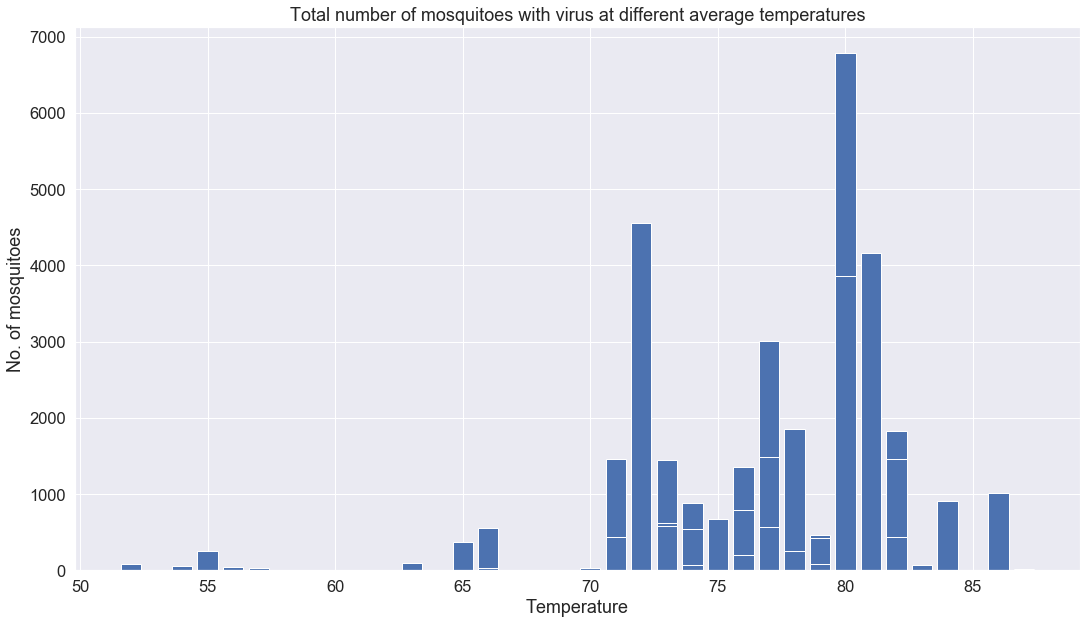

In [42]:
plt.figure(figsize=(18,10))
plt.bar(temp['Tavg'],temp['sum'])
plt.title("Total number of mosquitoes with virus at different average temperatures")
plt.xlabel("Temperature")
plt.ylabel("No. of mosquitoes")

#### Traps corresponding to the locations of highest number of mosquitoes 

In [43]:
#traps corresponding to the locations of highest number of mosquitoes 
total_mosquitoes = combined_train_.groupby(["Trap"])['NumMosquitos'].agg(['sum','count'])
total_mosquitoes= total_mosquitoes.sort_values(by="sum", ascending=False).head(20).reset_index()
#total_mosquitoes = total_mosquitoes.reset_index()

total_mosquitoes

Trap    sum  count
0   T115  15373     11
1   T138   7784      8
2   T900   5902     20
3   T128   2215      6
4   T103   1632      4
5   T002   1029     12
6   T030    976      7
7   T086    872      5
8   T225    839     10
9   T008    760      8
10  T135    675      5
11  T221    632      6
12  T212    615      3
13  T158    533      5
14  T009    515      6
15  T003    472     13
16  T233    457      4
17  T082    451      7
18  T903    442      6
19  T013    442      9

Text(0, 0.5, 'No. of mosquitoes')

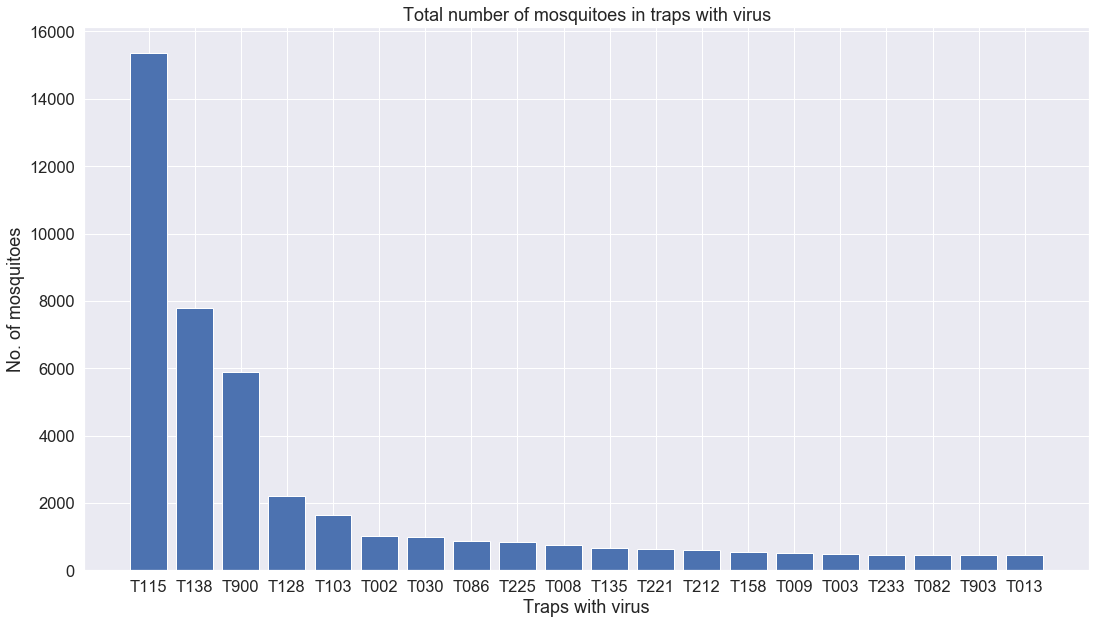

In [44]:
plt.figure(figsize=(18,10))
plt.bar(total_mosquitoes["Trap"],total_mosquitoes["sum"])
plt.title("Total number of mosquitoes in traps with virus")
plt.xlabel("Traps with virus")
plt.ylabel("No. of mosquitoes")

#### Grouping data into years as spray data contains only 2011 and 2013 data.

In [45]:
list_var={}
def grouping_by_year(data):
    grps = data.groupby("Year")
    grps_key = list(grps.groups.keys())
    for i in range(len(list(grps.groups.keys()))):
        list_var["grouped_data_{}".format(grps_key[i])] = grps.get_group(grps_key[i])
    return list_var, grps_key

In [46]:
grouping_by_year(combined_train)

({'grouped_data_2007':            Date  Trap   Latitude  Longitude  NumMosquitos  WnvPresent  Year  \
  0    2007-05-29  T002  41.954690 -87.800991             2           0  2007   
  1    2007-05-29  T148  42.017430 -87.687769             1           0  2007   
  2    2007-05-29  T143  41.999129 -87.795585             1           0  2007   
  3    2007-05-29  T015  41.974089 -87.824812             5           0  2007   
  4    2007-05-29  T007  41.994991 -87.769279             1           0  2007   
  5    2007-05-29  T159  41.732984 -87.649642             1           0  2007   
  6    2007-05-29  T153  41.907645 -87.760886             1           0  2007   
  7    2007-05-29  T129  41.891126 -87.611560             3           0  2007   
  8    2007-05-29  T094  41.720848 -87.666014             3           0  2007   
  9    2007-05-29  T091  41.862292 -87.648860             1           0  2007   
  10   2007-05-29  T086  41.688324 -87.676709             2           0  2007   
  11   

In [47]:
grouped_data_2007 = list_var["grouped_data_2007"]
grouped_data_2009 = list_var["grouped_data_2009"]
grouped_data_2011 = list_var["grouped_data_2011"]
grouped_data_2013 = list_var["grouped_data_2013"]

In [48]:
list_var2={}
def grouping_by_year_spray(data):
    grps = data.groupby("Year")
    grps_key = list(grps.groups.keys())
    for i in range(len(list(grps.groups.keys()))):
        list_var2["grouped_data_spray{}".format(grps_key[i])] = grps.get_group(grps_key[i])
    return list_var2, grps_key

In [49]:
grouping_by_year_spray(spray)

({'grouped_data_spray2011':            Date   Latitude  Longitude  Year  Month       YYMM
  0    2011-08-29  42.391623 -88.089163  2011      8  (2011, 8)
  1    2011-08-29  42.391348 -88.089163  2011      8  (2011, 8)
  2    2011-08-29  42.391022 -88.089157  2011      8  (2011, 8)
  3    2011-08-29  42.390637 -88.089158  2011      8  (2011, 8)
  4    2011-08-29  42.390410 -88.088858  2011      8  (2011, 8)
  5    2011-08-29  42.390395 -88.088315  2011      8  (2011, 8)
  6    2011-08-29  42.390673 -88.088002  2011      8  (2011, 8)
  7    2011-08-29  42.391027 -88.088002  2011      8  (2011, 8)
  8    2011-08-29  42.391403 -88.088003  2011      8  (2011, 8)
  9    2011-08-29  42.391718 -88.087995  2011      8  (2011, 8)
  10   2011-08-29  42.392038 -88.087988  2011      8  (2011, 8)
  11   2011-08-29  42.392410 -88.088078  2011      8  (2011, 8)
  12   2011-08-29  42.392800 -88.088332  2011      8  (2011, 8)
  13   2011-08-29  42.393257 -88.088370  2011      8  (2011, 8)
  14   2011-08

In [50]:
grouped_data_spray_2011 = list_var2["grouped_data_spray2011"]
grouped_data_spray_2013 = list_var2["grouped_data_spray2013"]

#### Visualizing the trap locations with mosquitoes in comparison with the spray locations

In [51]:
"""
# 2011
plt.scatter(grouped_data_spray_2011.Longitude, grouped_data_spray_2011.Latitude, c = 'r')
plt.scatter(grouped_data_2011.Longitude, grouped_data_2011.Latitude, c = grouped_data_2011.NumMosquitos)
plt.show()
"""

"\n# 2011\nplt.scatter(grouped_data_spray_2011.Longitude, grouped_data_spray_2011.Latitude, c = 'r')\nplt.scatter(grouped_data_2011.Longitude, grouped_data_2011.Latitude, c = grouped_data_2011.NumMosquitos)\nplt.show()\n"

In [52]:
"""
# 2013
plt.scatter(grouped_data_spray_2013.Longitude, grouped_data_spray_2013.Latitude, c = 'r')
plt.scatter(grouped_data_2013.Longitude, grouped_data_2013.Latitude, c = grouped_data_2013.NumMosquitos)
plt.show()
"""

"\n# 2013\nplt.scatter(grouped_data_spray_2013.Longitude, grouped_data_spray_2013.Latitude, c = 'r')\nplt.scatter(grouped_data_2013.Longitude, grouped_data_2013.Latitude, c = grouped_data_2013.NumMosquitos)\nplt.show()\n"

In [53]:
Nummos_bydate = combined_train.groupby(["Date"])['NumMosquitos'].agg(['sum']).reset_index()
Nummos_bydate = pd.DataFrame(Nummos_bydate )
Nummos_bydate .sort_values("Date")

Date   sum
0  2007-05-29    40
1  2007-06-05   127
2  2007-06-26   216
3  2007-06-29    85
4  2007-07-02   240
5  2007-07-11  1103
6  2007-07-18   853
7  2007-07-19   687
8  2007-07-25  4069
9  2007-07-27   247
10 2007-08-01  6904
11 2007-08-02  2898
12 2007-08-03   204
13 2007-08-07  1780
14 2007-08-08  4186
15 2007-08-09   507
16 2007-08-15  4661
17 2007-08-16  4555
18 2007-08-17  1915
19 2007-08-21  1667
20 2007-08-22  4512
21 2007-08-24  1478
22 2007-08-28  4748
23 2007-09-04   524
24 2007-09-05  2021
25 2007-09-06  1511
26 2007-09-12  1193
27 2007-09-18   392
28 2007-09-19  1756
29 2007-09-24  1570
..        ...   ...
65 2011-07-25  2449
66 2011-07-29  1408
67 2011-08-05  1065
68 2011-08-12   824
69 2011-08-19   589
70 2011-08-26   490
71 2011-09-01   319
72 2011-09-02   551
73 2011-09-12   734
74 2011-09-16   821
75 2011-09-23   728
76 2011-09-30   184
77 2013-06-07   360
78 2013-06-14  1670
79 2013-06-21  1319
80 2013-06-27   439
81 2013-06-28   923
82 2013-07-08  1833
83 2013-07-12  4796
84 2013-07-19  4168
85 2013-07-25  1974
86 2013-08-01  2865
87 2013-08-08  3188
88 2013-08-15  1946
89 2013-08-22  2063
90 2013-08-29  2645
91 2013-09-06  2510
92 2013-09-12  2210
93 2013-09-19  1030
94 2013-09-26   505

[95 rows x 2 columns]

In [54]:
spray["spray"] = 1
Spray_bydate = spray.groupby(["Date"])["spray"].agg(['sum']).reset_index()
Spray_bydate = pd.DataFrame(Spray_bydate )
Spray_bydate .sort_values("Date")

Date   sum
0 2011-08-29    95
1 2011-09-07  2114
2 2013-07-17  2202
3 2013-07-25  1607
4 2013-08-08  1195
5 2013-08-15  2668
6 2013-08-16   141
7 2013-08-22  1587
8 2013-08-29  2302
9 2013-09-05   924

In [55]:
combined_spray_train = pd.merge(Spray_bydate, Nummos_bydate, how="outer", left_on="Date", right_on="Date")

In [56]:
#clean the data frame for combined spray/train data
combined_spray_train.Date.fillna(combined_spray_train.Date, inplace=True)
del combined_spray_train['Date']
combined_spray_train.rename(columns={"sum_x": "Num_spray", "sum_y": "NumMosquitos"}, inplace=True)

In [57]:
combined_spray_train

Num_spray  NumMosquitos
0        95.0           NaN
1      2114.0           NaN
2      2202.0           NaN
3      1607.0        1974.0
4      1195.0        3188.0
5      2668.0        1946.0
6       141.0           NaN
7      1587.0        2063.0
8      2302.0        2645.0
9       924.0           NaN
10        NaN          40.0
11        NaN         127.0
12        NaN         216.0
13        NaN          85.0
14        NaN         240.0
15        NaN        1103.0
16        NaN         853.0
17        NaN         687.0
18        NaN        4069.0
19        NaN         247.0
20        NaN        6904.0
21        NaN        2898.0
22        NaN         204.0
23        NaN        1780.0
24        NaN        4186.0
25        NaN         507.0
26        NaN        4661.0
27        NaN        4555.0
28        NaN        1915.0
29        NaN        1667.0
..        ...           ...
70        NaN         830.0
71        NaN         846.0
72        NaN        1944.0
73        NaN        2091.0
74        NaN        2497.0
75        NaN        2449.0
76        NaN        1408.0
77        NaN        1065.0
78        NaN         824.0
79        NaN         589.0
80        NaN         490.0
81        NaN         319.0
82        NaN         551.0
83        NaN         734.0
84        NaN         821.0
85        NaN         728.0
86        NaN         184.0
87        NaN         360.0
88        NaN        1670.0
89        NaN        1319.0
90        NaN         439.0
91        NaN         923.0
92        NaN        1833.0
93        NaN        4796.0
94        NaN        4168.0
95        NaN        2865.0
96        NaN        2510.0
97        NaN        2210.0
98        NaN        1030.0
99        NaN         505.0

[100 rows x 2 columns]

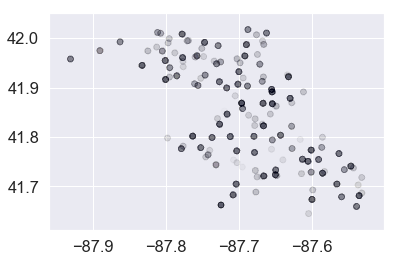

In [58]:
# look at dispersion of virus incidence geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.WnvPresent, alpha = .01)

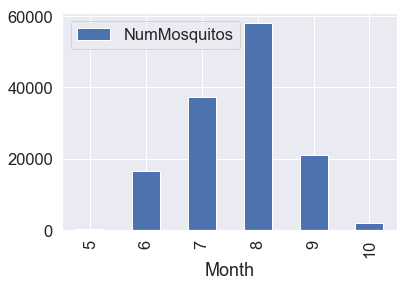

In [59]:
# look at incidence of cases over months
agg_train[['Month', 'NumMosquitos']].groupby("Month").sum().plot(kind='bar')

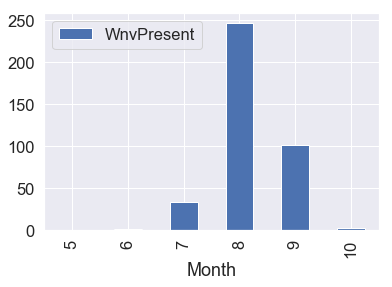

In [60]:
# look at incidence of cases over months
agg_train[['Month', 'WnvPresent']].groupby("Month").sum().plot(kind='bar')

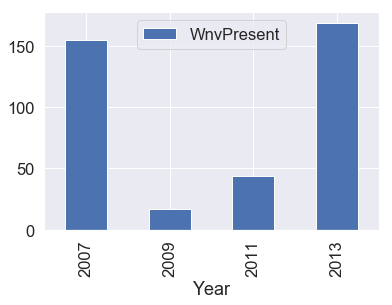

In [61]:
# look at incidence of cases over years
agg_train[['Year', 'WnvPresent']].groupby('Year').sum().plot(kind='bar')

# Creating dummy variables for year, month and traps

In [62]:
df_sample = combined_train

In [65]:
df_sample['Date']

0      2007-05-29
1      2007-05-29
2      2007-05-29
3      2007-05-29
4      2007-05-29
5      2007-05-29
6      2007-05-29
7      2007-05-29
8      2007-05-29
9      2007-05-29
10     2007-05-29
11     2007-05-29
12     2007-05-29
13     2007-05-29
14     2007-05-29
15     2007-05-29
16     2007-05-29
17     2007-05-29
18     2007-06-05
19     2007-06-05
20     2007-06-05
21     2007-06-05
22     2007-06-05
23     2007-06-05
24     2007-06-05
25     2007-06-05
26     2007-06-05
27     2007-06-05
28     2007-06-05
29     2007-06-05
          ...    
4586   2013-09-26
4587   2013-09-26
4588   2013-09-26
4589   2013-09-26
4590   2013-09-26
4591   2013-09-26
4592   2013-09-26
4593   2013-09-26
4594   2013-09-26
4595   2013-09-26
4596   2013-09-26
4597   2013-09-26
4598   2013-09-26
4599   2013-09-26
4600   2013-09-26
4601   2013-09-26
4602   2013-09-26
4603   2013-09-26
4604   2013-09-26
4605   2013-09-26
4606   2013-09-26
4607   2013-09-26
4608   2013-09-26
4609   2013-09-26
4610   201

In [66]:
df_sample['Date_x'] = pd.to_datetime(df_sample['Date'])

In [67]:
df_sample['day'] = df_sample['Date_x'].dt.day

In [68]:
weekday = pd.DataFrame([df_sample.iloc[i, 0].weekday() for i in range(len(df_sample))], columns=["Weekday"])

In [69]:
weekday_dm = pd.get_dummies(weekday['Weekday'])

In [70]:
#0-Monday
weekday_dm.head()

0  1  2  3  4
0  0  1  0  0  0
1  0  1  0  0  0
2  0  1  0  0  0
3  0  1  0  0  0
4  0  1  0  0  0

In [71]:
weekday_dm.drop(columns=4,inplace=True)

In [72]:
weekday_dm.rename(columns={0: "monday", 1: "tuesday", 2: "wednesday", 3: "thursday"},inplace=True)

In [73]:
weekday_dm.head()

monday  tuesday  wednesday  thursday
0       0        1          0         0
1       0        1          0         0
2       0        1          0         0
3       0        1          0         0
4       0        1          0         0

In [74]:
df_sample.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent',
       'Year', 'Month', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
       'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Daytime', 'YYMM', 'Date_x',
       'day'],
      dtype='object')

In [75]:
#it works like this datetime.date(year, month, day(this case is date then convert to day)).isocalendar to find the week in that year
week_list = [datetime.date(df_sample.iloc[i,6], df_sample.iloc[i,7], df_sample.iloc[i,-1]).isocalendar()[1] for i in range(len(df_sample))]

In [76]:
week = pd.DataFrame(week_list, columns=['Week'])

In [77]:
week.head()

Week
0    22
1    22
2    22
3    22
4    22

In [78]:
week_dm = pd.get_dummies(week['Week'])

In [79]:
week_dm.head()

22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  \
0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   41  
0   0  
1   0  
2   0  
3   0  
4   0

In [80]:
#drop one of hte weeks due to the dummy, based on this it is quite evident across all years only some weeks are involved.
week_dm.drop(columns=41, inplace=True)

In [81]:
#Create dummies for the month data
month_dm = pd.get_dummies(df_sample['Month'])

In [82]:
month_dm.head()

5   6   7   8   9   10
0   1   0   0   0   0   0
1   1   0   0   0   0   0
2   1   0   0   0   0   0
3   1   0   0   0   0   0
4   1   0   0   0   0   0

In [83]:
#this might be good for visualizations
df_sample['Month'].value_counts()

8     1363
9     1143
7     1093
6      816
10     142
5       59
Name: Month, dtype: int64

In [84]:
#remove one column for the month data
month_dm.drop(columns=5, inplace=True)

In [85]:
month_dm.rename(columns ={6: "june", 7: 'july', 8: 'august', 9: 'september', 10: 'october'}, inplace=True)

In [86]:
month_dm.columns

Index(['june', 'july', 'august', 'september', 'october'], dtype='object')

In [87]:
#get dummies for year and remove one column (year 2013)
year_dm = pd.get_dummies(df_sample['Year'])

In [88]:
year_dm.head()

2007  2009  2011  2013
0     1     0     0     0
1     1     0     0     0
2     1     0     0     0
3     1     0     0     0
4     1     0     0     0

In [89]:
year_dm.drop(columns=2013, inplace=True)

In [90]:
year_dm.head()

2007  2009  2011
0     1     0     0
1     1     0     0
2     1     0     0
3     1     0     0
4     1     0     0

In [91]:
df_sample['Trap'] = df_sample['Trap'].apply(lambda x: x[:4])

In [92]:
#check if the extra values are removed. it should retain as the original trap which adds in an extra observation for training.
for i in range(len(df_sample['Trap'])):
    if len(df_sample.iloc[i,1]) > 4:
        print('Trap with extra suffix not removed')
    else:
        pass

In [93]:
traps_dm = pd.get_dummies(df_sample['Trap'])

In [94]:
traps_dm.columns

Index(['T001', 'T002', 'T003', 'T004', 'T005', 'T006', 'T007', 'T008', 'T009',
       'T011',
       ...
       'T230', 'T231', 'T232', 'T233', 'T235', 'T236', 'T237', 'T238', 'T900',
       'T903'],
      dtype='object', length=134)

In [95]:
#Remove the last trap information T903
traps_dm.drop(columns='T903', inplace=True)

In [96]:
#so now we have traps_dm, year_dm, month_dm, week_dm, weekday_dm. We will concat it to our original df
combined_train.head()
#to drop date_x, year, month, traps because they are represented as dummies already.

Date  Trap   Latitude  Longitude  NumMosquitos  WnvPresent  Year  \
0 2007-05-29  T002  41.954690 -87.800991             2           0  2007   
1 2007-05-29  T148  42.017430 -87.687769             1           0  2007   
2 2007-05-29  T143  41.999129 -87.795585             1           0  2007   
3 2007-05-29  T015  41.974089 -87.824812             5           0  2007   
4 2007-05-29  T007  41.994991 -87.769279             1           0  2007   

   Month  Station  Tmax  ...  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  \
0      5        1    88  ...          0.0        29.39     30.11          5.8   
1      5        1    88  ...          0.0        29.39     30.11          5.8   
2      5        1    88  ...          0.0        29.39     30.11          5.8   
3      5        1    88  ...          0.0        29.39     30.11          5.8   
4      5        1    88  ...          0.0        29.39     30.11          5.8   

   ResultDir  AvgSpeed  Daytime       YYMM     Date_x day  
0         18       6.5      896  (2007, 5) 2007-05-29  29  
1         18       6.5      896  (2007, 5) 2007-05-29  29  
2         18       6.5      896  (2007, 5) 2007-05-29  29  
3         18       6.5      896  (2007, 5) 2007-05-29  29  
4         18       6.5      896  (2007, 5) 2007-05-29  29  

[5 rows x 33 columns]

In [97]:
combined_train.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent',
       'Year', 'Month', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
       'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Daytime', 'YYMM', 'Date_x',
       'day'],
      dtype='object')

In [98]:
df_1 = pd.concat([combined_train, year_dm], axis=1)

In [99]:
df_2 = pd.concat([combined_train, month_dm, week_dm, weekday_dm,traps_dm], axis=1)

In [100]:
df_2.shape

(4616, 194)

In [101]:
#check for objects to drop. Other columns to drop: Tmin, Tmax, Lat, Long, NumMosquitoes, WNVpresent, daytime
#Other columns to drop: the columns that were replaced.
cols = df_2.columns[df_2.dtypes.eq('object')]

In [102]:
cols

Index(['Trap', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall',
       'StnPressure', 'SeaLevel', 'YYMM'],
      dtype='object')

In [103]:
weekday_dm.dtypes

monday       uint8
tuesday      uint8
wednesday    uint8
thursday     uint8
dtype: object

In [104]:
#Test data has this trap that is not reflected in the training data. To ensure it is able to compare, we include a new column
df_2['T234'] = 0

In [105]:
combined_train=df_2

In [106]:
df_2.shape

(4616, 195)

## Baseline

In [107]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns



plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [114]:
X = combined_train.drop(["Latitude", "Longitude", "WnvPresent", "YYMM", "NumMosquitos", 'Trap', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall',
       'StnPressure', 'SeaLevel', 'Tmin', 'Tmax', 'Daytime', 'Date_x', 'Year', 'Month', 'day', 'Date'], axis=1)
y = combined_train.WnvPresent

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [116]:
class model_evaluation:
   
    def __init__(self, y_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        self.score = F1_score

In [117]:
lr_model = LogisticRegression()

In [118]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test,predicted_lr)
lrg.confusion_matrix ()
lr.score (X_test, y_test)

True Negatives: 1053
False Positives: 3
False Negatives: 90
True Positives: 8
Precision: 0.7272727272727273
Recall: 0.08163265306122448
F1 score: 0.14678899082568805


/Users/evan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9194107452339688

In [119]:
probability = lr.predict_proba(X_test)[:,1]
roc_auc_score(y_test, probability)

0.8236027365491652

In [120]:
list_2 = zip(list(X.columns), list(lr.coef_))

Text(0, 0.5, 'Feature Importance Score')

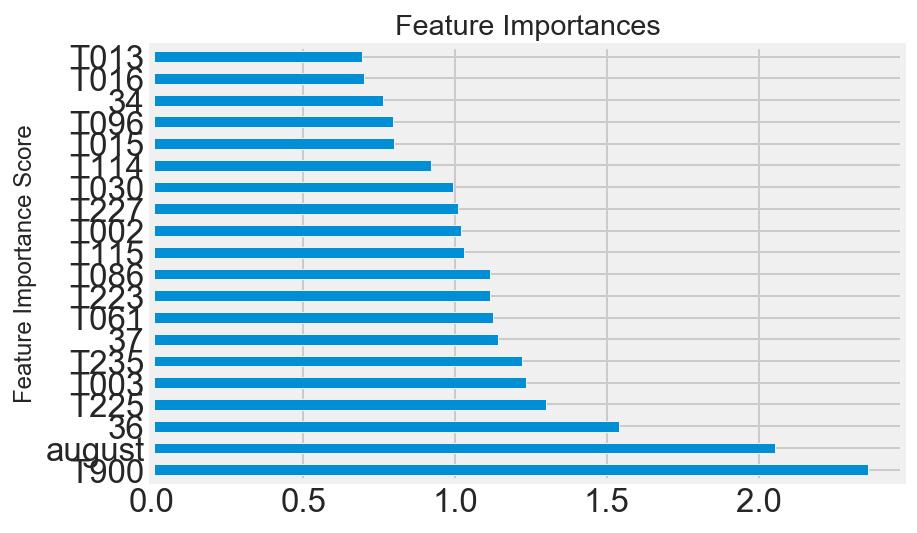

In [121]:
list_2 = zip(list(X.columns), list(lr.coef_[0]))
pl = pd.Series(dict(list_2)).sort_values(ascending=False).head(20)
pl.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
probability_y = lr.predict_proba(X_fin_test)[:,1]
#roc_auc_score(y_test, probability)

### MODELS

In [ ]:
#Test code, scaling of data, reduction of dimensionality, use of SVC.
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', SVC(kernel = 'linear', C = 1, probability=True))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))


''' sample codes
#params={'model__C':[.01,.05,.1,.5,1,5,10],
           'model__penalty':['l1','l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression())])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')
grid.fit(train['text'], train['output'])
grid.score(test['text'], test['output'])


#pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVC(kernel = 'linear', C = 1))])

param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring= 'accuracy')
grid.fit(X, y)
print(grid.best_score_)
print(grid.cv_results_)
'''

In [ ]:
grid.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', SVC(kernel = 'linear', C = 1, probability=True))])
param_grid = dict(clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
#KNN
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', KNeighborsClassifier())])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_neighbors=range(1, 201, 10),
                  clf__metric=['euclidean', 'manhattan'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier())])
param_grid = dict(clf__n_neighbors=range(1, 201, 10),
                  clf__metric=['euclidean', 'manhattan'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
#Multinomial is not applicable here due to the need for vectorizing, Decision trees will be used
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', DecisionTreeClassifier())])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__max_depth=[None,1,2,3,4,5],
                  clf__max_features=['sqrt', 'log2', None],
                  clf__min_samples_split=[2,3,4,5,10,15,20,25,30,40,50])


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))


'''
n_params = {
    'max_depth': [None,1,2,3,4,5],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2,3,4,5,10,15,20,25,30,40,50]
    }

grid3 = GridSearchCV(DecisionTreeClassifier(), n_params, cv=5)
grid3.fit(X,y)
print ('best score = {}'.format(grid3.best_score_))
grid3.best_params_
'''


In [ ]:
grid.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier())])
param_grid = dict(clf__max_depth=[None,1,2,3,4,5],
                  clf__max_features=['sqrt', 'log2', None],
                  clf__min_samples_split=[2,3,4,5,10,15,20,25,30,40,50])


grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
#Example of feature importance: grid.best_estimator_.steps[1][1].feature_importances_
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#Random forest- of course we need a random search first yeah?
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', RandomForestClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_estimators=[int(x) for x in np.linspace(200, 2000, 10)],
                  clf__max_features=['auto', 'sqrt'],
                  clf__max_depth=max_depth,
                  clf__min_samples_split=[2, 5, 10],
                  clf__min_samples_leaf=[1, 2, 4],
                  clf__bootstrap=[True, False]
                 )


rc_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
rc_random.fit(X_train, y_train)

In [ ]:
rc_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=8)),
    ('clf', RandomForestClassifier(max_features='sqrt', n_estimators=2000, bootstrap=True, min_samples_leaf=4 ,random_state=42))])

param_grid = dict(clf__max_depth=[95, 105],
                  clf__min_samples_split = [8, 10, 12],
                  clf__min_samples_leaf = [4, 6, 8]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
#Random Forest without PCA
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))])
param_grid = dict(clf__n_estimators=[int(x) for x in np.linspace(200, 2000, 10)],
                  clf__max_features=['auto', 'sqrt'],
                  clf__max_depth=max_depth,
                  clf__min_samples_split=[2, 5, 10],
                  clf__min_samples_leaf=[1, 2, 4],
                  clf__bootstrap=[True, False]
                 )


rc_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
rc_random.fit(X_train, y_train)

In [ ]:
rc_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier())])

param_grid = dict(clf__max_features=['auto', 'sqrt']
                 )


grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False).head(20)
pl.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

# Incorporate test data to have same columns as the train dataset

In [122]:
#clean up the test data set now, ensure it has the same number of columns (follow the steps above)
combined_test.head()

Id     Date_x  Trap  Latitude  Longitude  Year  Month  Station  Tmax  Tmin  \
0   1 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
1   2 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
2   3 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
3   4 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
4   5 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   

   ...  Water1  SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  \
0  ...       M       0.0          0.0        29.28     29.99          8.9   
1  ...       M       0.0          0.0        29.28     29.99          8.9   
2  ...       M       0.0          0.0        29.28     29.99          8.9   
3  ...       M       0.0          0.0        29.28     29.99          8.9   
4  ...       M       0.0          0.0        29.28     29.99          8.9   

  ResultDir AvgSpeed Daytime       YYMM  
0        18     10.0     910  (2008, 6)  
1        18     10.0     910  (2008, 6)  
2        18     10.0     910  (2008, 6)  
3        18     10.0     910  (2008, 6)  
4        18     10.0     910  (2008, 6)  

[5 rows x 30 columns]

In [123]:
df_sample_test = combined_test

In [124]:
df_sample_test['Date_x'] = pd.to_datetime(df_sample_test['Date_x'])

In [125]:
df_sample_test['Year'].value_counts()

2010    36557
2008    30498
2012    27115
2014    22123
Name: Year, dtype: int64

In [126]:
df_sample['Year'].value_counts()

2007    1459
2013    1163
2009    1006
2011     988
Name: Year, dtype: int64

In [127]:
df_sample_test.columns

Index(['Id', 'Date_x', 'Trap', 'Latitude', 'Longitude', 'Year', 'Month',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Daytime', 'YYMM'],
      dtype='object')

In [128]:
weekday = pd.DataFrame([df_sample_test.iloc[i, 1].weekday() for i in range(len(df_sample_test))], columns=["Weekday"])

In [129]:
weekday_dm = pd.get_dummies(weekday['Weekday'])

In [130]:
#0-Monday
weekday_dm.head()

0  1  2  3  4
0  0  0  1  0  0
1  0  0  1  0  0
2  0  0  1  0  0
3  0  0  1  0  0
4  0  0  1  0  0

In [131]:
weekday_dm.drop(columns=4,inplace=True)

In [132]:
weekday_dm.rename(columns={0: "monday", 1: "tuesday", 2: "wednesday", 3: "thursday"},inplace=True)

In [133]:
weekday_dm.head()

monday  tuesday  wednesday  thursday
0       0        0          1         0
1       0        0          1         0
2       0        0          1         0
3       0        0          1         0
4       0        0          1         0

In [134]:
df_sample_test['day'] = df_sample_test['Date_x'].dt.day

In [135]:
df_sample_test.columns

Index(['Id', 'Date_x', 'Trap', 'Latitude', 'Longitude', 'Year', 'Month',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Daytime', 'YYMM', 'day'],
      dtype='object')

In [136]:
#it works like this datetime.date(year, month, day(this case is date then convert to day)).isocalendar to find the week in that year
week_list = [datetime.date(df_sample_test.iloc[i,5], df_sample_test.iloc[i,6], df_sample_test.iloc[i,-1]).isocalendar()[1] for i in range(len(df_sample_test))]

In [137]:
week = pd.DataFrame(week_list, columns=['Week'])

In [138]:
week_dm = pd.get_dummies(week['Week'])

In [139]:
week_dm.columns

Int64Index([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40],
           dtype='int64')

In [140]:
#Create dummies for the month data
month_dm = pd.get_dummies(df_sample_test['Month'])

In [141]:
month_dm.head()

6   7   8   9   10
0   1   0   0   0   0
1   1   0   0   0   0
2   1   0   0   0   0
3   1   0   0   0   0
4   1   0   0   0   0

In [142]:
#this might be good for visualizations
df_sample_test['Month'].value_counts()

7     35665
8     33115
9     25612
6     19478
10     2423
Name: Month, dtype: int64

In [143]:
#Supposed to remove one column for the month data but choose not to remove unnecesaary data that it originally has

In [144]:
month_dm.rename(columns ={6: "june", 7: 'july', 8: 'august', 9: 'september', 10:'october'}, inplace=True)

In [145]:
month_dm.columns

Index(['june', 'july', 'august', 'september', 'october'], dtype='object')

In [146]:
#Decided not to use year data as train and test are in different years
#year_dm = pd.get_dummies(df_sample['Year'])

In [147]:
#Move on to trap data. Intuitively this should be the most important because it is closest to number of mosquitoes and location.
df_sample_test['Trap'] = df_sample_test['Trap'].apply(lambda x: x[:4])

In [148]:
#check if the extra values are removed. it should retain as the original trap which adds in an extra observation for training.
for i in range(len(df_sample_test['Trap'])):
    if len(df_sample_test.iloc[i,2]) > 4:
        print('Trap with extra suffix not removed')
    else:
        pass

In [149]:
traps_dm = pd.get_dummies(df_sample_test['Trap'])

In [150]:
traps_dm.columns

Index(['T001', 'T002', 'T003', 'T004', 'T005', 'T006', 'T007', 'T008', 'T009',
       'T011',
       ...
       'T231', 'T232', 'T233', 'T234', 'T235', 'T236', 'T237', 'T238', 'T900',
       'T903'],
      dtype='object', length=135)

In [151]:
#Remove the last trap information T903
traps_dm.drop(columns='T903', inplace=True)

In [152]:
combined_test.head()

Id     Date_x  Trap  Latitude  Longitude  Year  Month  Station  Tmax  Tmin  \
0   1 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
1   2 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
2   3 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
3   4 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   
4   5 2008-06-11  T002  41.95469 -87.800991  2008      6        1    86    61   

   ...  SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
0  ...       0.0          0.0        29.28     29.99          8.9         18   
1  ...       0.0          0.0        29.28     29.99          8.9         18   
2  ...       0.0          0.0        29.28     29.99          8.9         18   
3  ...       0.0          0.0        29.28     29.99          8.9         18   
4  ...       0.0          0.0        29.28     29.99          8.9         18   

  AvgSpeed Daytime       YYMM day  
0     10.0     910  (2008, 6)  11  
1     10.0     910  (2008, 6)  11  
2     10.0     910  (2008, 6)  11  
3     10.0     910  (2008, 6)  11  
4     10.0     910  (2008, 6)  11  

[5 rows x 31 columns]

In [153]:
combined_test.columns

Index(['Id', 'Date_x', 'Trap', 'Latitude', 'Longitude', 'Year', 'Month',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Daytime', 'YYMM', 'day'],
      dtype='object')

In [154]:
df_3 = pd.concat([combined_test, month_dm, week_dm, weekday_dm,traps_dm], axis=1)

In [155]:
df_3.shape

(116293, 193)

In [156]:
df_3 = pd.concat([combined_test, month_dm, week_dm, weekday_dm,traps_dm], axis=1)

In [157]:
df_3.shape

(116293, 193)

In [158]:
df_2.shape

(4616, 195)

In [159]:
df_3['T234'].value_counts()

0    115533
1       760
Name: T234, dtype: int64

In [160]:
760/115533*100

0.6578207092345909

In [161]:
df_3[df_3['T234']==1]

Id     Date_x  Trap   Latitude  Longitude  Year  Month  Station  \
344       1145 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
345       1146 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
346       1147 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
347       1148 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
348       1149 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
349       1150 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
350       1151 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
351       1152 2008-06-11  T234  41.942285 -87.761726  2008      6        1   
1552      2353 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1553      2354 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1554      2355 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1555      2356 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1556      2357 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1557      2358 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1558      2359 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
1559      2360 2008-06-17  T234  41.942285 -87.761726  2008      6        1   
2768      3570 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2769      3571 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2770      3572 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2771      3573 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2772      3574 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2773      3575 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2774      3576 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
2775      3577 2008-06-24  T234  41.942285 -87.761726  2008      6        1   
3980      4781 2008-07-01  T234  41.942285 -87.761726  2008      7        1   
3981      4782 2008-07-01  T234  41.942285 -87.761726  2008      7        1   
3982      4783 2008-07-01  T234  41.942285 -87.761726  2008      7        1   
3983      4784 2008-07-01  T234  41.942285 -87.761726  2008      7        1   
3984      4785 2008-07-01  T234  41.942285 -87.761726  2008      7        1   
3985      4786 2008-07-01  T234  41.942285 -87.761726  2008      7        1   
...        ...        ...   ...        ...        ...   ...    ...      ...   
111785  112586 2014-09-11  T234  41.942285 -87.761726  2014      9        1   
111786  112587 2014-09-11  T234  41.942285 -87.761726  2014      9        1   
111787  112588 2014-09-11  T234  41.942285 -87.761726  2014      9        1   
111788  112589 2014-09-11  T234  41.942285 -87.761726  2014      9        1   
111789  112590 2014-09-11  T234  41.942285 -87.761726  2014      9        1   
111790  112591 2014-09-11  T234  41.942285 -87.761726  2014      9        1   
113003  113804 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113004  113805 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113005  113806 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113006  113807 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113007  113808 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113008  113809 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113009  113810 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
113010  113811 2014-09-18  T234  41.942285 -87.761726  2014      9        1   
114221  115022 2014-09-25  T234  41.942285 -87.761726  2014      9        1   
114222  115023 2014-09-25  T234  41.942285 -87.761726  2014      9        1   
114223  115024 2014-09-25  T234  41.942285 -87.761726  2014      9        1   
114224  115025 2014-09-25  T234  41.942285 -87.761726  2014      9        1   
114225  115026 2014-09-25  T234  41.942285 -87.761726  2014   

In [162]:
[i for i in df_3.columns if i not in df_2.columns]

['Id']

In [163]:
[i for i in df_2.columns if i not in df_3.columns]

['Date', 'NumMosquitos', 'WnvPresent']

In [164]:
combined_test = df_3

In [165]:
#X_fin_test and X_train has to have the same columns
X_fin_test = combined_test.drop(["Id", "Latitude", "Longitude", "YYMM", 'Trap', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall',
       'StnPressure', 'SeaLevel', 'Tmin', 'Tmax', 'Daytime', 'Date_x', 'Year', 'Month', 'day'], axis=1)

# Predicting the values again using the test data with the right columns

In [ ]:
#note that combined test contains only the columns of X and we will use this directly for our predict_proba
probability_y = grid.predict_proba(X_fin_test)[:,1]

In [ ]:
probability_y=pd.DataFrame(probability_y, columns=['WnvPresent'])

In [ ]:
probability_y.head()

In [ ]:
combined_test.head()

In [ ]:
probability_y['Id'] = combined_test['Id']

In [ ]:
probability_y.head()

In [ ]:
#swap the columns around for submission
cols = probability_y.columns.tolist()

In [ ]:
cols = cols[-1:] + cols[:-1]

In [ ]:
cols

In [ ]:
probability_y = probability_y[cols] 

In [ ]:
probability_y.head()

In [ ]:
probability_y.to_csv('./kaggle-submit(10).csv')

# Other models that were tried

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', AdaBoostClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_estimators=[150, 200],
                  clf__learning_rate=[0.01,0.05,0.1,0.3,1],
                 )


ad_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
ad_random.fit(X_train, y_train)


In [ ]:
ad_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=6)),
    ('clf', AdaBoostClassifier(random_state=42))])

param_grid = dict(clf__n_estimators=[200,250],
                  clf__learning_rate=[0.1,0.2,0.25,0.3,0.35]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
#Adaboost without PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=42))])
param_grid = dict(clf__n_estimators=[150, 200],
                  clf__learning_rate=[0.01,0.05,0.1,0.3,1],
                 )


ad_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
ad_random.fit(X_train, y_train)

In [ ]:
ad_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=42))])

param_grid = dict(clf__n_estimators=[200,250],
                  clf__learning_rate=[0.1,0.2,0.25,0.3,0.35]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
probability = grid.predict_proba(X_test)[:,1]
print(grid.best_score_)
print(grid.cv_results_)
print(roc_auc_score(y_test, probability))

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False).head(20)
pl.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#Gradientboosting with PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', GradientBoostingClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__min_samples_split=[50, 100],
                  clf__min_samples_leaf=[1,2,4],
                  clf__max_features=['auto','sqrt', 'log2'],
                  clf__max_depth = [5,6,7,8]
                 )

gb_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
gb_random.fit(X_train, y_train)

In [ ]:
gb_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=8)),
    ('clf', GradientBoostingClassifier(min_samples_leaf=2, max_depth= 6,random_state=42))])

param_grid = dict(clf__min_samples_split=[100,150],
                  clf__max_features=['auto','sqrt', 'log2']
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#gradientboosting without PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))])
param_grid = dict(clf__min_samples_split=[50, 100],
                  clf__min_samples_leaf=[1,2,4],
                  clf__max_features=['auto','sqrt', 'log2'],
                  clf__max_depth = [5,6,7,8]
                 )

gb_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
gb_random.fit(X_train, y_train)

In [ ]:
gb_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', GradientBoostingClassifier(min_samples_leaf=2, max_features= 'log2',random_state=42))])

param_grid = dict(clf__min_samples_split=[30,50,70],
                  clf__max_depth=[8,10]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False).head(20)
pl.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Some takeaways, random forest seems to do the best. PCA did not really help much and could be due to small number of features. Adaboost learning rate seems to balance off with the estimators. higher estimators = lower learning rate. When doing decision trees, features that are the most important is heavily skewed to number of mosquitos. Baseline should be treated as 94% because this is supposed to be rare. Considering a binary classification problem, one can always assume the mosquito is not infected and still get it right 94% of the time.

Moving forward: Makes sense to predict the number of mosquitos first? then do a classification? Read other solutions. Find ways to process the features, date/time stuff and encoding of some of the categorical ones. Break the baseline.

Done: Pipelines Gridsearch Randomized search PCA